## ASK joint: NicheNet preparations

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3               
sc.logging.print_version_and_date()

# making sure plots & clusters are reproducible
np.random.seed(42)

# custom functions
import sc_toolbox as sct

Running Scanpy 1.8.2, on 2022-04-30 16:15.


In [2]:
## path variables
adata_dir = '/home/niklas/data/220107_Human_PCLS_ASK_joint/220107_PCLS_human_ASK_joint_annotated_NIKLAS.h5ad'
project_dir = '/home/niklas/projects/niche_environments_FIBROSIS/HUMAN_exvivo/01_data/NicheNet_inputs/'

In [3]:
## plotting variables
sc.settings.figdir = '/home/niklas/projects/niche_environments_FIBROSIS/PCLS_human/02_figures/ASK_joint/'
sc.set_figure_params(vector_friendly = True)
plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['pdf.fonttype'] = 42

In [4]:
## load anndata object
adata = sc.read(adata_dir)

In [5]:
## have a look at the adata object
adata

AnnData object with n_obs × n_vars = 63581 × 17343
    obs: 'condition', 'modality', 'name', 'patient', 'timepoint', 'treatment', 'identifier', 'n_counts', 'n_genes', 'percent_mito', 'QC_group', 'doublet_scores', 'size_factors', 'leiden_1', 'leiden_2', 'cell_type', 'cell_type_group'
    var: 'n_cells', 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'cell_type_colors', 'cell_type_group_colors', 'condition_colors', 'dendrogram_cell_type', 'hvg', 'identifier_colors', 'leiden', 'leiden_1_colors', 'leiden_2_colors', 'modality_colors', 'name_colors', 'neighbors', 'patient_colors', 'pca', 'rank_genes_groups', 'treatment_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'unsouped_counts'
    obsp: 'connectivities', 'distances'

In [6]:
#adata = adata[adata.obs.treatment.isin(['CC','FC'])].copy()

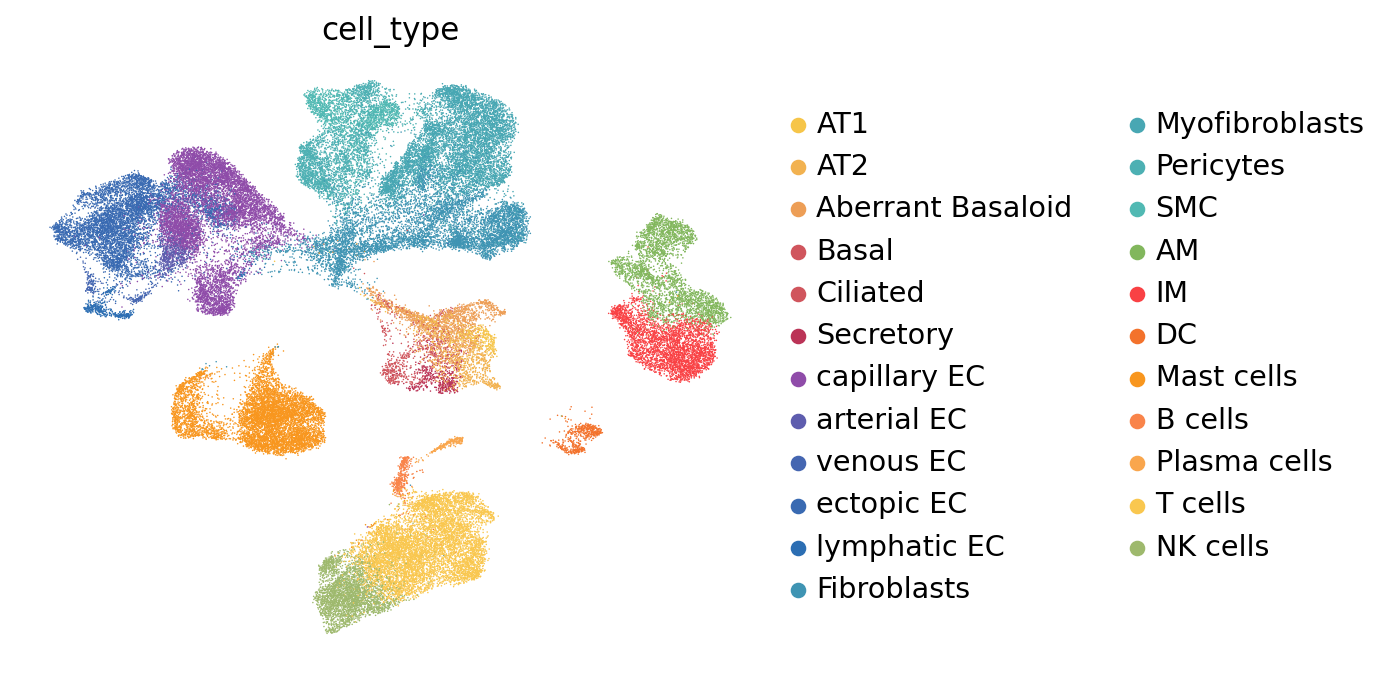

In [7]:
## overview UMAPs
sc.pl.umap(adata, color = ['cell_type'], ncols = 1, frameon = False)

/home/niklas/miniconda3/envs/niche_fibrosis_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


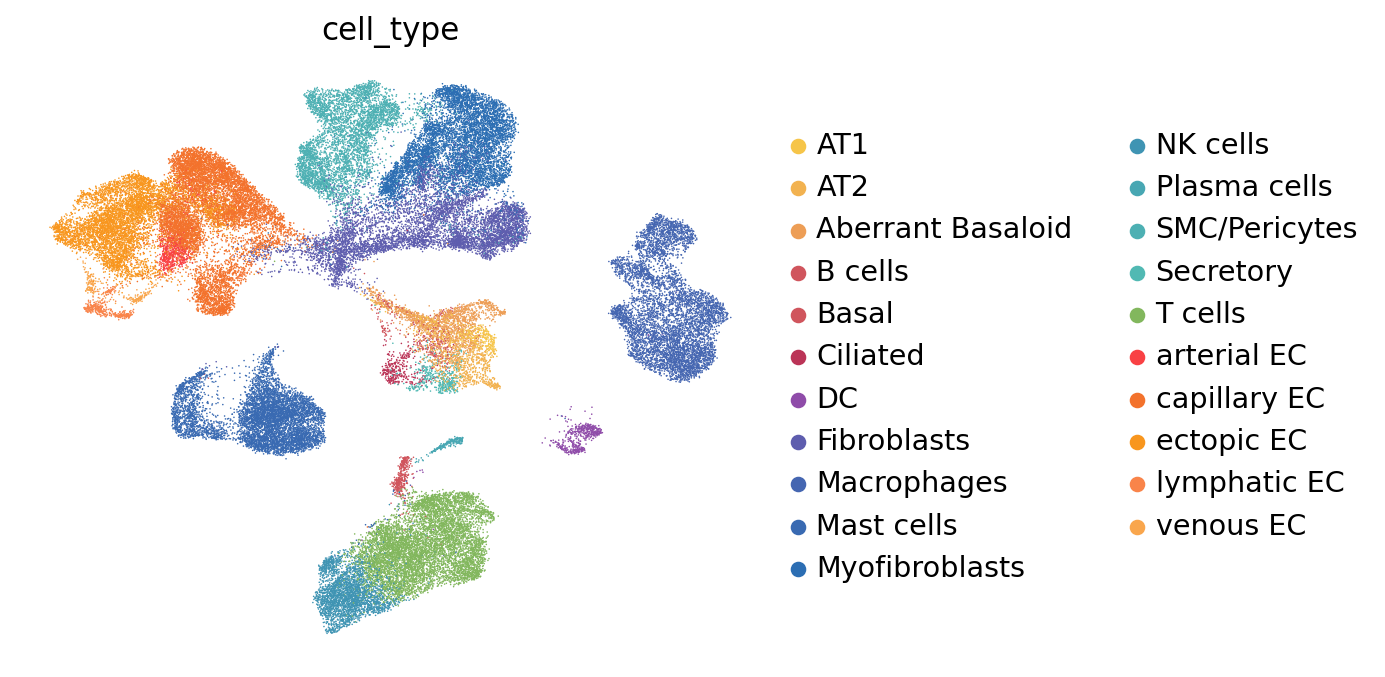

In [8]:
adata.obs['cell_type'] = ['Macrophages' if ct in ['AM','IM'] else ct for ct in adata.obs['cell_type']]
adata.obs['cell_type'] = ['SMC/Pericytes' if ct in ['SMC','Pericytes'] else ct for ct in adata.obs['cell_type']]
sc.pl.umap(adata, color = 'cell_type', size = 2, frameon = False)

In [9]:
### get overview of cell type proportions and numbers
pd.crosstab(adata.obs['cell_type'],adata.obs['treatment'])

treatment,CC,FC,FC+CMP4,FC+Nintedanib
cell_type,,,,
AT1,276,90,53,27
AT2,431,16,185,8
Aberrant Basaloid,429,691,366,294
B cells,89,114,110,92
Basal,176,50,58,23
Ciliated,53,159,84,77
DC,72,218,102,159
Fibroblasts,3625,969,621,1478
Macrophages,1540,1894,2179,832


### Calculate average expression table

In [10]:
## for each condition separately
for treatment in ['CC','FC','FC+CMP4','FC+Nintedanib']:
    adata_sub = adata[adata.obs.treatment.isin([treatment])].copy()
    avg_expr_ct = pd.DataFrame(columns=adata_sub.var_names, index=adata_sub.obs['cell_type'].cat.categories)                                                                                                 
    for cell_type in adata_sub.obs.cell_type.cat.categories: 
        avg_expr_ct.loc[cell_type] = adata_sub[adata_sub.obs['cell_type'].isin([cell_type]),:].X.mean(0)
    avg_expr_ct = avg_expr_ct.transpose()
    avg_expr_ct_SCALED = avg_expr_ct.apply(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)), axis = 1)
    avg_expr_ct.to_csv(project_dir + '220207_ASK_joint_Human_PCLS_' + treatment + '_avg_expr_cell_type_level.csv')
    avg_expr_ct_SCALED.to_csv(project_dir + '220207_ASK_joint_Human_PCLS_' + treatment + '_avg_expr_SCALED_cell_type_level.csv')

In [11]:
## for each treatment separately - but always pooled with CC
for treatment in ['FC','FC+CMP4','FC+Nintedanib']:
    adata_sub = adata[adata.obs.treatment.isin(['CC',treatment])].copy()
    avg_expr_ct = pd.DataFrame(columns=adata_sub.var_names, index=adata_sub.obs['cell_type'].cat.categories)                                                                                                 
    for cell_type in adata_sub.obs.cell_type.cat.categories: 
        avg_expr_ct.loc[cell_type] = adata_sub[adata_sub.obs['cell_type'].isin([cell_type]),:].X.mean(0)
    avg_expr_ct = avg_expr_ct.transpose()
    avg_expr_ct_SCALED = avg_expr_ct.apply(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)), axis = 1)
    avg_expr_ct.to_csv(project_dir + '220207_ASK_joint_Human_PCLS_CC_' + treatment + '_avg_expr_cell_type_level.csv')
    avg_expr_ct_SCALED.to_csv(project_dir + '220207_ASK_joint_Human_PCLS_CC_' + treatment + '_avg_expr_SCALED_cell_type_level.csv')

### Calculate pct expression tables
- CC + FC
- CC + FC/CMP4
- CC + FC/Nintedanib

In [12]:
## for each condition separately
for treatment in ['CC','FC','FC+CMP4','FC+Nintedanib']:
    adata_sub = adata[adata.obs.treatment.isin([treatment])].copy()
    pct_expr_ct = pd.DataFrame(columns=adata_sub.raw.var_names, index=adata_sub.obs['cell_type'].cat.categories) 
    for cell_type in adata_sub.obs.cell_type.cat.categories:
        cells = adata_sub.obs_names[adata_sub.obs['cell_type'] == cell_type]
        pct_expr_ct.loc[cell_type] = (adata_sub.raw[cells].X > 0).sum(0) / adata_sub.raw[cells].X.shape[0]
    pct_expr_ct = pct_expr_ct.transpose()
    pct_expr_ct.to_csv(project_dir + '220207_ASK_joint_Human_PCLS_' + treatment + '_pct_expr_cell_type_level.csv')

In [13]:
## for each treatment separately - but always pooled with CC
for treatment in ['FC','FC+CMP4','FC+Nintedanib']:
    adata_sub = adata[adata.obs.treatment.isin(['CC',treatment])].copy()
    pct_expr_ct = pd.DataFrame(columns=adata_sub.raw.var_names, index=adata_sub.obs['cell_type'].cat.categories) 
    for cell_type in adata_sub.obs.cell_type.cat.categories:
        cells = adata_sub.obs_names[adata_sub.obs['cell_type'] == cell_type]
        pct_expr_ct.loc[cell_type] = (adata_sub.raw[cells].X > 0).sum(0) / adata_sub.raw[cells].X.shape[0]
    pct_expr_ct = pct_expr_ct.transpose()
    pct_expr_ct.to_csv(project_dir + '220207_ASK_joint_Human_PCLS_CC_' + treatment + '_pct_expr_cell_type_level.csv')

In [14]:
### Fibroblast avg expr table for Michael

In [15]:
adata = adata[adata.obs.patient.isin(['ASK627'])]

In [16]:
### create cell type + treatment column
adata.obs['cell_type_treatment'] = adata.obs.loc[:, ['cell_type_group', 'treatment']].agg('_'.join, axis = 1)
sc._utils.sanitize_anndata(adata)

Trying to set attribute `.obs` of view, copying.
/home/niklas/miniconda3/envs/niche_fibrosis_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type_treatment' as categorical


In [17]:
adata.obs['cell_type_treatment'].value_counts()

capillary EC_CC                      4648
Fibroblasts_CC                       3281
T cells_FC                           2636
vascular EC_FC                       2333
Fibroblasts_FC+CMP4                  2278
Fibroblasts_FC                       2253
T cells_FC+Nintedanib                2218
Mast cells_FC                        2192
Mast cells_FC+Nintedanib             2171
Fibroblasts_FC+Nintedanib            2142
Macrophages_FC+CMP4                  1659
vascular EC_FC+Nintedanib            1420
Macrophages_FC                       1292
vascular EC_FC+CMP4                  1253
NK cells_FC                          1124
Macrophages_CC                       1046
T cells_FC+CMP4                       952
Alveolar Epithelium_CC                919
Mast cells_FC+CMP4                    865
SMC/Pericytes_FC                      855
NK cells_FC+Nintedanib                850
SMC/Pericytes_FC+Nintedanib           842
vascular EC_CC                        819
capillary EC_FC+Nintedanib        

In [18]:
avg_expr = pd.DataFrame(columns=adata.var_names, index=adata.obs['cell_type_treatment'].cat.categories)                                                                                                 
for c in adata.obs.cell_type_treatment.cat.categories: 
    avg_expr.loc[c] = adata[adata.obs['cell_type_treatment'].isin([c]),:].X.mean(0)

In [19]:
avg_expr = avg_expr.transpose()

In [20]:
avg_expr

,Airway Epithelium_CC,Airway Epithelium_FC,Airway Epithelium_FC+CMP4,Airway Epithelium_FC+Nintedanib,Alveolar Epithelium_CC,Alveolar Epithelium_FC,Alveolar Epithelium_FC+CMP4,Alveolar Epithelium_FC+Nintedanib,B cells_CC,B cells_FC,...,capillary EC_FC+CMP4,capillary EC_FC+Nintedanib,lymphatic EC_CC,lymphatic EC_FC,lymphatic EC_FC+CMP4,lymphatic EC_FC+Nintedanib,vascular EC_CC,vascular EC_FC,vascular EC_FC+CMP4,vascular EC_FC+Nintedanib
SAMD11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000656,0.000394,0.0
NOC2L,0.125598,0.088377,0.082043,0.092492,0.140797,0.11472,0.113335,0.137408,0.087878,0.10053,...,0.078512,0.167739,0.139986,0.123577,0.062484,0.094665,0.109873,0.107695,0.109049,0.119541
KLHL17,0.007497,0.012374,0.005595,0.004683,0.010555,0.011973,0.010787,0.013943,0.0,0.0,...,0.021044,0.022493,0.008105,0.010812,0.014488,0.013623,0.005731,0.015829,0.014388,0.022884
PLEKHN1,0.019436,0.033892,0.042864,0.011753,0.055628,0.075328,0.062638,0.087867,0.0,0.0,...,0.001986,0.000322,0.0,0.016232,0.007208,0.0,0.002082,0.001114,0.001268,0.0
PERM1,0.0,0.0,0.0,0.0,0.000906,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000126,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC011043.1,0.003973,0.014781,0.00614,0.013955,0.006434,0.011065,0.004535,0.002413,0.0,0.0,...,0.016975,0.012296,0.014164,0.040794,0.038478,0.037101,0.028374,0.02707,0.025611,0.02583
AL592183.1,0.0,0.0067,0.005768,0.002815,0.006569,0.003657,0.005005,0.0,0.0,0.0,...,0.013376,0.009483,0.007701,0.0,0.006135,0.0,0.002766,0.002851,0.004029,0.001855
AC007325.4,0.014059,0.028745,0.015962,0.022311,0.011687,0.017768,0.030223,0.008765,0.0,0.0,...,0.001838,0.002352,0.005434,0.011351,0.0,0.0,0.002578,0.002656,0.003534,0.001797
AL354822.1,0.006494,0.011769,0.014714,0.012121,0.009645,0.009626,0.005169,0.006639,0.0,0.008548,...,0.015599,0.022754,0.027699,0.025136,0.040267,0.027658,0.015944,0.013181,0.017822,0.019064


In [21]:
avg_expr.to_csv(project_dir + '220430_ASK627_Human_PCLS_avg_expr_ct_treatments.csv')